## Introducción

Entrenamiento de modelo preentrenado para resolver el problema de predecir el ángulo del auto en base a la imagen.

Fuertemente basado en:
- https://towardsdatascience.com/a-practical-example-in-transfer-learning-with-pytorch-846bb835f2db
- https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html 

## Imports

In [1]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
from torchmetrics import MetricCollection, Accuracy, Precision, Recall, F1, ConfusionMatrix
import pandas as pd
import sklearn
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from matplotlib.pyplot import imshow

## Variables

In [2]:
MODEL_NAME = ""

## Dataset

Se crea un dataset de tipo `ImageFolder` que se toma de la carpeta `dataset`, donde cada subcarpeta es una de las categorías a entrenar. 

Automáticamente mapea categorías a números `dataset.class_to_idx`.

Finalmente se hace el split en train y test en 80/20.

In [79]:
dataset = datasets.ImageFolder(
    'dataset_paragolpe',
    transforms.Compose([
        transforms.ColorJitter(0.1, 0.1, 0.1, 0.1),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
)

print(dataset.classes)
print(dataset.class_to_idx)

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [len(dataset) - 100, 100])

['no_paragolpe_del', 'paragolpe_del_roto', 'paragolpe_del_sano']
{'no_paragolpe_del': 0, 'paragolpe_del_roto': 1, 'paragolpe_del_sano': 2}


In [95]:
len(dataset.imgs)

533

In [84]:
def inverse_normalize(tensor):
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

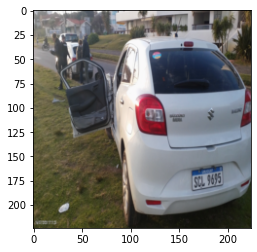

In [85]:
denormalized = inverse_normalize(train_dataset[0][0])
imshow(denormalized.permute(1,2,0))

## Loaders
Luego, se crean loaders para cada uno de los conjuntos. Los loaders permiten procesar los datos de a batches.

In [22]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4
)

## Model

En este step se carga el modelo pre-entrenado. Para este ejemplo se utiliza el modelo alexnet por su simplicidad.

In [23]:
model = models.alexnet(pretrained=True)
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### ¿Finetuning o Feature extraction?

- **Finetuning:** Consiste en incializar la red con los pesos pre-entrenados, y re-entrenar toda la red (ajustar los parámetros de todas las capas) con el dataset custom.
- **Feature extraction:** La diferencia con lo anterior es que se congelan las capas convolucionales, de modo que el entrenamiento no las cambie con nuestros datos.

En ambos casos pisamos la capa de **clasificador** por una capa nueva con 8 categorías, porque el modelo pre-entrenado tiene 1000 labels.

In [24]:
NUM_CLASSES = len(dataset.classes)
feature_extraction = False

if feature_extraction:
    for param in model.parameters():
        param.requires_grad = False

print(model.classifier)
model.classifier[6] = torch.nn.Linear(model.classifier[6].in_features, NUM_CLASSES)
print(model.classifier)

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)
Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=3, bias=True)
)


Para correr en GPU o CPU:

In [25]:
device_string = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_string)
model = model.to(device)

### Metrics

In [91]:
writer = SummaryWriter() 

def init_metrics():
    return MetricCollection({
        'macro_acc': Accuracy(num_classes=len(dataset.classes), average='macro'),
        'macro_prec': Precision(num_classes=len(dataset.classes), average='macro'),
        'macro_rec': Recall(num_classes=len(dataset.classes), average='macro'),
        'macro_f1': Recall(num_classes=len(dataset.classes), average='macro'),
        'acc': Accuracy(num_classes=len(dataset.classes), average='none'),
        'prec': Precision(num_classes=len(dataset.classes), average='none'),
        'rec': Recall(num_classes=len(dataset.classes), average='none'),
        'f1': Recall(num_classes=len(dataset.classes), average='none'),
        'confusion_matrix': ConfusionMatrix(num_classes=len(dataset.classes))
    }).to(device)

def print_macro_metrics(metric_computed):
    print('-'*25 + ' MACRO METRICS ' + '-'*25)
    print()
    print('Macro Accuracy {}'.format(metric_computed["macro_acc"]))
    print('Macro Precision {}'.format(metric_computed["macro_prec"]))
    print('Macro Recall {}'.format(metric_computed["macro_rec"]))
    print('Macro F1 {}'.format(metric_computed["macro_f1"]))
    print()
    
def print_per_class_metrics(metric_computed):
    classes = dataset.classes
    print('-'*25 + ' PER CLASS METRICS ' + '-'*25)

    metric_table = {"class": [], "accuracy":[], "precision": [], "recall": [], "f1": []}
    for (i, class_name) in enumerate(classes):
        metric_table["class"].append(class_name)
        metric_table["accuracy"].append(metric_computed["acc"][i].item())
        metric_table["precision"].append(metric_computed["prec"][i].item())
        metric_table["recall"].append(metric_computed["rec"][i].item())
        metric_table["f1"].append(metric_computed["f1"][i].item())

    display(pd.DataFrame(metric_table))
    
def record_macro_metrics(phase, epoch, metric_computed, epoch_loss):
    writer.add_scalar('{}/Loss'.format(phase), epoch_loss, epoch)
    writer.add_scalar('{}/Accuracy'.format(phase), metric_computed["macro_acc"], epoch)
    writer.add_scalar('{}/Precision'.format(phase), metric_computed["macro_prec"], epoch)
    writer.add_scalar('{}/Recall'.format(phase), metric_computed["macro_rec"], epoch)
    writer.add_scalar('{}/F1'.format(phase), metric_computed["macro_f1"], epoch)
    writer.flush()

### Entrenamiento

In [27]:
import time
NUM_EPOCHS = 6
BEST_MODEL_PATH = 'best_model_paragolpe.pth'
best_f1 = 0.0

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

for epoch in range(NUM_EPOCHS):
    print("Epoch: {}".format(epoch))
    
    # Train phase
    start = time.time()
    model.train()
    
    train_metrics = init_metrics()
    train_epoch_loss = 0.0
    
    for images, labels in iter(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        
        outputs = model(images)
        
        train_metrics(outputs, labels)
        loss = F.cross_entropy(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        train_epoch_loss += loss.item() * images.size(0)
    
    train_metrics_computed = train_metrics.compute()
    train_epoch_loss /= len(train_dataset)
    record_macro_metrics('train', epoch, train_metrics_computed, train_epoch_loss)
    end = time.time()
    
    print("Train time: {}s".format(end - start))
    
    # Test phase
    model.eval()
    test_metrics = init_metrics()
    test_epoch_loss = 0.0
    
    for images, labels in iter(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            outputs = model(images)
            
            test_metrics(outputs, labels)
            loss = F.cross_entropy(outputs, labels)
            
            test_epoch_loss += loss.item() * images.size(0)
            
    test_metrics_computed = test_metrics.compute()
    test_epoch_loss /= len(test_dataset)
    
    print_macro_metrics(test_metrics_computed)
    record_macro_metrics('test', epoch, test_metrics_computed, test_epoch_loss)
    test_f1 = test_metrics_computed["macro_f1"]
    
    if test_f1 > best_f1:
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        best_f1 = test_f1

Epoch: 0
Train time: 49.57354021072388s
------------------------- MACRO METRICS -------------------------

Macro Accuracy 0.6440613269805908
Macro Precision 0.6942307949066162
Macro Recall 0.6440613269805908
Macro F1 0.6440613269805908

Epoch: 1
Train time: 48.7397198677063s
------------------------- MACRO METRICS -------------------------

Macro Accuracy 0.6720306873321533
Macro Precision 0.6951538324356079
Macro Recall 0.6720306873321533
Macro F1 0.6720306873321533

Epoch: 2
Train time: 48.32802200317383s
------------------------- MACRO METRICS -------------------------

Macro Accuracy 0.8111111521720886
Macro Precision 0.7864137887954712
Macro Recall 0.8111111521720886
Macro F1 0.8111111521720886

Epoch: 3
Train time: 46.30686807632446s
------------------------- MACRO METRICS -------------------------

Macro Accuracy 0.8157088160514832
Macro Precision 0.7699275016784668
Macro Recall 0.8157088160514832
Macro F1 0.8157088160514832

Epoch: 4
Train time: 47.48201394081116s
-------------

## Evaluación final

In [86]:
def preprocess_img(img):
    return inverse_normalize(img)
    

In [92]:
model.load_state_dict(torch.load('best_model_paragolpe.pth'))
model.eval()

metrics = init_metrics()

for i, (images, labels) in enumerate(test_loader):
    images = images.to(device)
    labels = labels.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        metrics(outputs, labels)
        
        predictions = torch.argmax(outputs, dim=1)
        for sampleno in range(images.shape[0]):
            if(labels[sampleno] != predictions[sampleno]):
                name = 'Misclasified_Predicted-{}_Classified-{}/{}'.format(classes[predictions[sampleno]], classes[labels[sampleno]], sampleno)
                
                #print(images[sampleno].permute(1,2,0))
                writer.add_image(name, preprocess_img(images[sampleno]))
                writer.flush()
                #imshow(images[sampleno].permute(1,2,0))

metrics_result = metrics.compute()
print_macro_metrics(metrics_result)
print_per_class_metrics(metrics_result)

------------------------- MACRO METRICS -------------------------

Macro Accuracy 0.8157088160514832
Macro Precision 0.7699275016784668
Macro Recall 0.8157088160514832
Macro F1 0.8157088160514832

------------------------- PER CLASS METRICS -------------------------


,class,accuracy,precision,recall,f1
0,no_paragolpe_del,0.913793,1.000000,0.913793,0.913793
1,paragolpe_del_roto,0.700000,0.875000,0.700000,0.700000
2,paragolpe_del_sano,0.833333,0.434783,0.833333,0.833333


In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

classes = dataset.classes

df_cm = pd.DataFrame(metrics_result['confusion_matrix'], index = classes,
                  columns = classes)

df_cm = df_cm.applymap(lambda x: x.item())

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)